<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_5_sarcasm_with_bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a Sarcasm Detection Model using Bidirectional LSTMs

In this lab, you will revisit the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home) dataset and use it to train a Bi-LSTM Model.


## Download the Dataset

First, you will download the JSON file and extract the contents into lists.

In [3]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-04-08 17:22:33--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.07s   

2023-04-08 17:22:33 (75.3 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [4]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Split the Dataset

You will then split the lists into train and test sets.

In [5]:
print(f'Total length: {len(sentences)}')

training_size = 20000

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

Total length: 26709


## Data preprocessing

Next, you will generate the vocabulary and padded sequences.

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Padding Sample: [1152 2530    3 3974 4302   11   29  662   50   13   11 5084    1    3
    4 5085    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [18]:
index = 1501

print(f'Training sentence Sample: {training_sentences[index]}')
print(f'Padding Sample: {training_padded[index]}')

Training sentence Sample: 'snl' version of angela merkel is not happy donald trump is time's 'person of the year'
Padding Sample: [1152 2530    3 3974 4302   11   29  662   50   13   11 5084    1    3
    4 5085    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## Build and Compile the Model

The architecture here is almost identical to the one you used in the previous lab with the IMDB Reviews. Try to tweak the parameters and see how it affects the training time and accuracy (both training and validation).

In [7]:
import tensorflow as tf

# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [8]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

Epoch 1/10
625/625 [==============================] - 38s 41ms/step - loss: 0.4159 - accuracy: 0.7934 - val_loss: 0.3300 - val_accuracy: 0.8556
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.2193 - accuracy: 0.9108 - val_loss: 0.3633 - val_accuracy: 0.8544
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 0.1421 - accuracy: 0.9475 - val_loss: 0.3832 - val_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0894 - accuracy: 0.9699 - val_loss: 0.4978 - val_accuracy: 0.8407
Epoch 5/10
625/625 [==============================] - 11s 18ms/step - loss: 0.0531 - accuracy: 0.9826 - val_loss: 0.6506 - val_accuracy: 0.8433
Epoch 6/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0348 - accuracy: 0.9887 - val_loss: 0.6853 - val_accuracy: 0.8372
Epoch 7/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0238 - accuracy: 0.9922 - val_loss: 0.7954 - val_accuracy: 

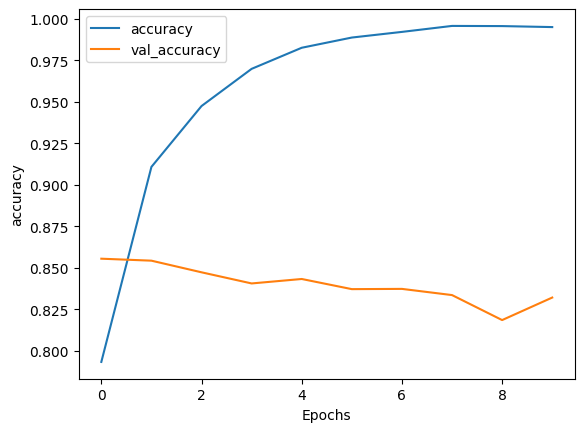

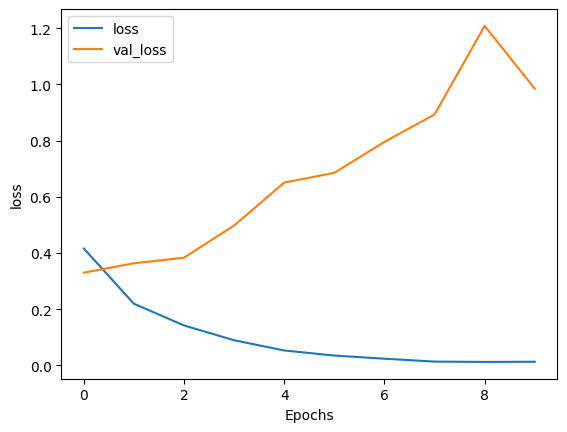

In [9]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')